In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pymodulon.enrichment import *
from sklearn.metrics import jaccard_score
from scipy.stats import spearmanr

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 14

In [2]:
# p1k data
p1k_A = pd.read_csv('../data/p1k/A.csv', index_col=0)
p1k_M = pd.read_csv('../data/p1k/M.csv', index_col=0)
imodulon_table = pd.read_csv('../data/p1k/iM_table.csv', index_col=1)
p1k_genes = pd.read_csv('../data/p1k/gene_info.csv', index_col=0)
p1k_genes.index.name = 'locus'
sample_data = pd.read_csv('../data/p1k/sample_table.csv', index_col=0)
p1k_X = pd.read_csv('../data/p1k/log_tpm.csv', index_col=0)

p1k_A.index = imodulon_table.index
p1k_M.columns = imodulon_table.index

p1k_gene_presence = pd.read_csv('../data/p1k/gene_presence_matrix.csv', index_col=0).astype(int)
p1k_gene_presence.columns = imodulon_table.index

trn_p1k = pd.read_csv('../data/p1k/trn.csv', index_col=0)

In [3]:
# NCA Results full trn
NCA_A = pd.read_csv('../data/NCA/full_trn/NCA_Activity.csv', index_col=0)
NCA_gene_presence = pd.read_csv('../data/NCA/full_trn/NCA_A_TRN.csv', index_col=0)

gene_mapping = pd.read_csv('../data/p1k/Gene-Name-from-All-genes-of-E.-coli-K-12-substr.-MG1655.txt', sep='\t')
gene_mapping.columns = ['gene_names', 'locus', 'synonyms']
gene_mapping = gene_mapping.replace({'phnE1':'phnE', 'lfgA':'yfjX', 'lfgB':'yfjY', 'lptM':'yifL'})
gene_mapping = gene_mapping[gene_mapping.locus.isin(p1k_genes.index)]

def get_locus_tag(gene_name):
    if gene_name in gene_mapping.gene_names.values:
        return gene_mapping.reset_index().set_index('gene_names').loc[gene_name, 'locus']
    else: # one edge case, gene ruled pseudogene
        return 'b3681'

# NCA_gene_presence.index = [p1k_genes.reset_index().set_index('gene_name').loc[x, 'locus'] for x in NCA_gene_presence.index]
# NCA_gene_presence = NCA_gene_presence.reindex(p1k_gene_presence.index, fill_value=0)
NCA_gene_presence.index.name = 'gene_name'
NCA_gene_presence = NCA_gene_presence.reset_index()
NCA_gene_presence['locus'] = NCA_gene_presence.gene_name.apply(lambda x: get_locus_tag(x))
NCA_gene_presence = NCA_gene_presence.set_index('locus')
NCA_gene_presence = NCA_gene_presence.drop('gene_name', axis=1).astype(int)

trn_test = NCA_gene_presence
trn_test = trn_test.T.rename_axis('Source')\
  .reset_index()\
  .melt('Source', value_name='Weight', var_name='Target')\
  .query('Source != Target')\
  .reset_index(drop=True)
trn_test = trn_test.drop(trn_test[trn_test.Weight == 0].index)
trn_test.columns = ['regulator','gene_id','effect']
trn = trn_test

# trn = pd.read_csv('../data/NCA/reg_list.csv', index_col=0)
# trn['target'] = trn.target.apply(lambda x: p1k_genes.reset_index().set_index('gene_name')['locus'].get(x, np.nan))
# trn = trn.dropna()
# trn.columns = ['regulator','gene_id','effect']

In [4]:
# trn = trn_p1k # Uncomment to use p1k's trn for enrichment

# Test types of iModulons in relation to overlap with regulons

## Single reg iModulons

In [5]:
regulation_info = list(imodulon_table.regulator_readable.dropna().values)
single_regulation = [x for x in regulation_info if 'and' not in x and 'or' not in x]
len(set(single_regulation))

50

## Multiple Regulator iModulons

In [6]:
regulation_info = list(imodulon_table.regulator_readable.dropna().values)
mult_regulation = [x for x in regulation_info if ' and' in x or ' or' in x]
len(set(mult_regulation))

57

## Testing

In [7]:
# Function to split terms by 'and' and 'or'
def split_regulators(reg_list):
    result = []
    for reg in reg_list:
        # Split by 'and' or 'or' and trim spaces
        split_terms = [term.strip() for term in reg.replace(' and ', ',').replace(' or ', ',').split(',')]
        result.extend(split_terms)
    return result

# Call the function
split_list = set(split_regulators(regulation_info))

In [8]:
captured_regs = [x for x in split_list if x.lower() in trn.regulator.str.lower().unique()]
reg_outside_of_rdb = [x for x in split_list if x.lower() not in trn.regulator.str.lower().values]
not_captured_regs = [x for x in trn.regulator.unique() if x.lower() not in {x.lower() for x in split_list}]

In [9]:
len(captured_regs)

102

In [10]:
len(not_captured_regs)

161

In [11]:
len(trn.regulator.unique())

263

In [12]:
plotting_data = pd.DataFrame(columns = ['Captured', 'Size', 'Enriched'])
for reg in captured_regs:
    size = trn[trn.regulator.str.lower()==reg.lower()].regulator.value_counts().values[0]
    plotting_data.loc[reg] = ['Captured', size, None]
for reg in not_captured_regs:
    size = trn[trn.regulator.str.lower()==reg.lower()].regulator.value_counts().values[0]
    plotting_data.loc[reg] = ['Not Captured', size, None]
    enriched = False
    trn_temp = trn[trn.regulator.str.lower() == reg.lower()]
    for ica_column in p1k_gene_presence.columns:
        ica_genes = set(p1k_gene_presence.index[p1k_gene_presence[ica_column] == 1])
        trn_enrichment = compute_trn_enrichment(ica_genes,p1k_M.index,trn_temp, fdr=1e-5)
        if len(trn_enrichment) > 0:
            enriched = True
    if enriched == True:
        plotting_data.loc[reg, 'Enriched'] = 'Enriched'
if 'RNAP' in plotting_data.index:
    plotting_data = plotting_data.drop('RNAP')

In [17]:
df = pd.DataFrame(plotting_data)

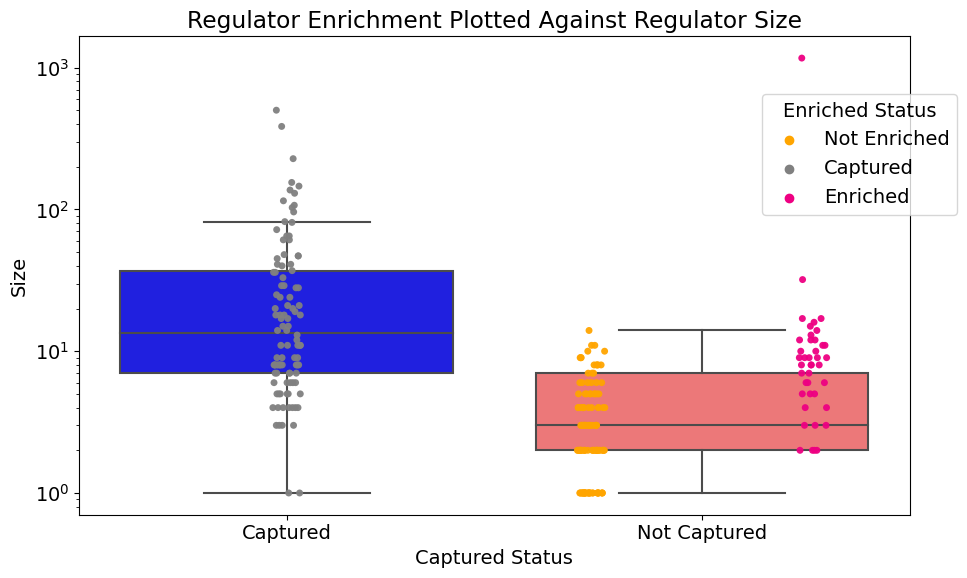

In [18]:
# Create a new column to mark if the regulator is enriched or not
df['Is_Enriched'] = df.apply(lambda row: 'Enriched' if row['Enriched'] == 'Enriched' and row['Captured'] == 'Not Captured' else ('Not Enriched' if row['Captured'] == 'Not Captured' else 'Captured'), axis=1)

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Captured', y='Size', data=df, showfliers=False, palette={'Captured': 'blue', 'Not Captured': '#FF6566'})

# Overlay the strip plot with the custom color palette
palette = {'Captured': 'grey', 'Enriched': '#EE0082', 'Not Enriched': 'orange'}
sns.stripplot(x='Captured', y='Size', data=df, hue='Is_Enriched', dodge=True, palette=palette, jitter=True, hue_order=['Not Enriched', 'Captured', 'Enriched'], alpha=.95)

# Add title and labels
plt.title('Regulator Enrichment Plotted Against Regulator Size')
plt.ylabel('Size')
plt.yscale('log')  # Adjust scale to log if necessary
plt.xlabel('Captured Status')

# Show the legend and plot
plt.legend(title='Enriched Status', bbox_to_anchor=(.81, .9), loc='upper left')
plt.tight_layout()
# plt.savefig('regulator_enrichment_plot.svg', format='svg', dpi=300)
plt.show()


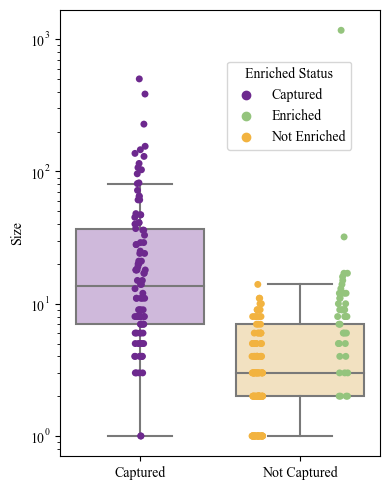

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# Use default style to prevent visual distortions from other styles
plt.style.use('default')

# Create the custom font properties
font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
font_prop = fm.FontProperties(fname=font_path)

# Create a new column to mark if the regulator is enriched or not
df['Is_Enriched'] = df.apply(
    lambda row: 'Enriched' if row['Enriched'] == 'Enriched' and row['Captured'] == 'Not Captured' 
    else ('Not Enriched' if row['Captured'] == 'Not Captured' else 'Captured'), 
    axis=1
)

# Create the box plot
plt.figure(figsize=(4, 5))

# Updated palette for the boxplot
box_palette = {'Captured': '#D1B3E1', 'Not Captured': '#FAE3B9'}
sns.boxplot(
    x='Captured', y='Size', data=df, showfliers=False, palette=box_palette
)

# Overlay the strip plot with a vibrant color palette
strip_palette = {
    'Enriched': '#94c47d',  # Vibrant pink
    'Not Enriched': '#f2b340',  # Deep yellow
    'Captured': '#6D298E'  # Deep blue
}
stripplot = sns.stripplot(
    x='Captured', y='Size', data=df, hue='Is_Enriched', dodge=True, 
    palette=strip_palette, jitter=True, 
    hue_order=['Not Enriched', 'Captured', 'Enriched'],  # Corrected order
    alpha=1
)

# Remove plot title and x-axis label
plt.ylabel('Size', fontproperties=font_prop)
plt.xlabel('')  # No x-axis label

# Set y-axis to logarithmic scale if necessary
plt.yscale('log')

# Adjust tick labels with custom font
plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)

# Adjust legend order: Captured, Enriched, Not Enriched
handles, labels = stripplot.get_legend_handles_labels()
order = [labels.index('Captured'), labels.index('Enriched'), labels.index('Not Enriched')]
plt.legend(
    [handles[i] for i in order], [labels[i] for i in order],
    title='Enriched Status', title_fontproperties=font_prop, 
    bbox_to_anchor=(.5, .9), loc='upper left', prop=font_prop
)

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the plot as an SVG file
plt.savefig('regulator_size_enrich.svg', format='svg')

# Display the plot
plt.show()

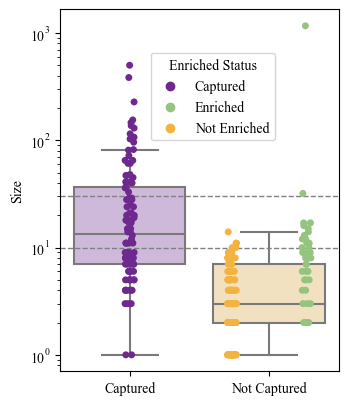

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# Use default style to prevent visual distortions from other styles
plt.style.use('default')

# Create the custom font properties
font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
font_prop = fm.FontProperties(fname=font_path)

# Create a new column to mark if the regulator is enriched or not
df['Is_Enriched'] = df.apply(
    lambda row: 'Enriched' if row['Enriched'] == 'Enriched' and row['Captured'] == 'Not Captured' 
    else ('Not Enriched' if row['Captured'] == 'Not Captured' else 'Captured'), 
    axis=1
)

# Create the box plot
plt.figure(figsize=(3.6, 4.7))

# Updated palette for the boxplot
box_palette = {'Captured': '#D1B3E1', 'Not Captured': '#FAE3B9'}
sns.boxplot(
    x='Captured', y='Size', data=df, showfliers=False, palette=box_palette
)

# Overlay the strip plot with a vibrant color palette
strip_palette = {
    'Enriched': '#94c47d',  # Vibrant pink
    'Not Enriched': '#f2b340',  # Deep yellow
    'Captured': '#6D298E'  # Deep blue
}
stripplot = sns.stripplot(
    x='Captured', y='Size', data=df, hue='Is_Enriched', dodge=True, 
    palette=strip_palette, jitter=True, 
    hue_order=['Not Enriched', 'Captured', 'Enriched'],  # Corrected order
    alpha=1
)

# Remove plot title and x-axis label
plt.ylabel('Size', fontproperties=font_prop)
plt.xlabel('')  # No x-axis label

# Add horizontal dotted lines at 10 and 30 (before setting log scale)
plt.axhline(10, linestyle='--', color='gray', linewidth=1)
plt.axhline(30, linestyle='--', color='gray', linewidth=1)

# Set y-axis to logarithmic scale
plt.yscale('log')

# Adjust tick labels with custom font
plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)

# Adjust legend order: Captured, Enriched, Not Enriched
handles, labels = stripplot.get_legend_handles_labels()
order = [labels.index('Captured'), labels.index('Enriched'), labels.index('Not Enriched')]
plt.legend(
    [handles[i] for i in order], [labels[i] for i in order],
    title='Enriched Status', title_fontproperties=font_prop, 
    bbox_to_anchor=(.3, .9), loc='upper left', prop=font_prop
)

# Save the plot as an SVG file
plt.savefig('regulator_size_enrich.svg', format='svg')

# Display the plot
plt.show()


In [14]:
df

,Captured,Size,Enriched,Is_Enriched
RpoS,Captured,228,None,Captured
BluR,Captured,4,None,Captured
PhoB,Captured,47,None,Captured
RpoE,Captured,107,None,Captured
NsrR,Captured,8,None,Captured
...,...,...,...,...
PunR,Not Captured,1,None,Not Enriched
YiaU,Not Captured,3,None,Not Enriched
CitR,Not Captured,2,None,Not Enriched
PtrR,Not Captured,3,Enriched,Enriched


In [15]:
df.sort_values('Size').groupby('Is_Enriched').Size.max()

Is_Enriched
Captured         501
Enriched        1168
Not Enriched      14
Name: Size, dtype: int64

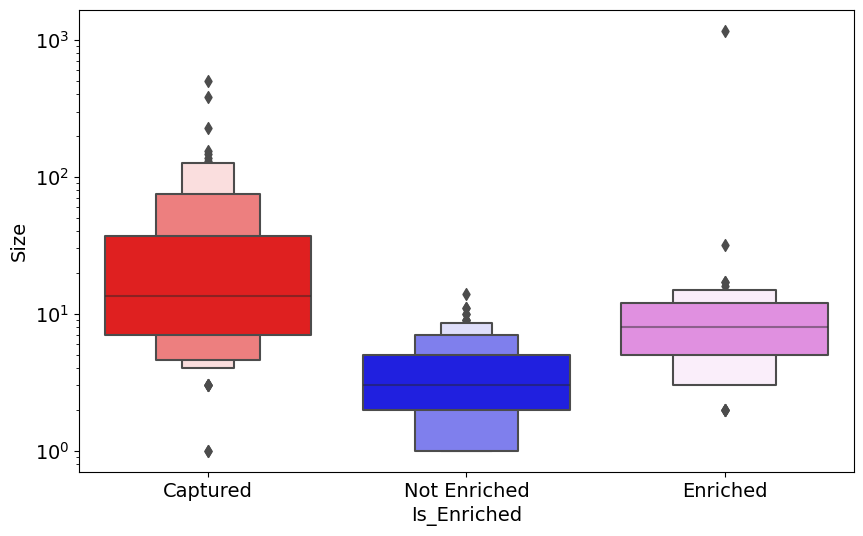

In [16]:
df = pd.DataFrame(plotting_data)

# Create a new column to mark if the regulator is enriched or not
df['Is_Enriched'] = df.apply(lambda row: 'Enriched' if row['Enriched'] == 'Enriched' and row['Captured'] == 'Not Captured' else ('Not Enriched' if row['Captured'] == 'Not Captured' else 'Captured'), axis=1)

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Is_Enriched', y='Size', data=df, showfliers=True, palette={'Captured':'red', 'Not Enriched': 'blue', 'Enriched':'violet'})
plt.yscale('log')

In [45]:
df.value_counts('Is_Enriched')

Is_Enriched
Not Enriched    119
Captured        102
Enriched         41
dtype: int64

In [46]:
df[df.Size < 4].Is_Enriched.value_counts()

Not Enriched    75
Enriched         7
Captured         6
Name: Is_Enriched, dtype: int64

In [49]:
trn[trn.regulator.str.lower().isin(captured_regs)].regulator.value_counts()

Series([], Name: regulator, dtype: int64)

In [50]:
trn[trn.regulator.str.lower().isin(not_captured_regs)].regulator.value_counts()

Series([], Name: regulator, dtype: int64)

In [51]:
count_enriched = 0
enriched_sizes = []
count_corr = 0
enriched = False
correlated = False
for reg in not_captured_regs:
    reg = reg.lower()
    trn_temp = trn[trn.regulator.str.lower() == reg]
    for ica_column in p1k_gene_presence.columns:
        ica_genes = set(p1k_gene_presence.index[p1k_gene_presence[ica_column] == 1])
        trn_enrichment = compute_trn_enrichment(ica_genes,p1k_M.index,trn_temp, fdr=1e-5)
        if len(trn_enrichment) > 0:
            enriched = True
            correlation = spearmanr(p1k_A.loc[ica_column], NCA_A.loc[NCA_A.index.str.lower() == reg].T)[0]
            display(ica_column,correlation, len(trn_temp), (trn_enrichment))
            if abs(correlation) > .7:
                correlated = True
                display(ica_column,correlation, len(trn_temp), (trn_enrichment))
    if enriched:
        count_enriched += 1
        enriched_sizes.append(len(trn_temp))
        enriched = False
    if correlated:
        count_corr += 1
        correlated = False

'RpoE'

0.4798931941529078

13

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
RcsB,3.684640e-08,0.307692,0.307692,0.307692,4.0,13.0,13.0,1.0,3.684640e-08


'baeR KO'

-0.13047611828978212

17

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
MraZ,8.172809e-16,0.185185,0.588235,0.28169,10.0,17.0,54.0,1.0,8.172809e-16


'N Reduction'

0.1648423866080258

1168

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
RpoD,2.786315e-14,1.0,0.020548,0.040268,24.0,1168.0,24.0,1.0,2.786315e-14


'Fur-1'

-0.014515558520953563

1168

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
RpoD,3.032783e-10,0.8125,0.02226,0.043333,26.0,1168.0,32.0,1.0,3.032783e-10


'Nitrate/Nitrite'

0.25753573571627986

1168

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
RpoD,0.000009,1.0,0.007705,0.015293,9.0,1168.0,9.0,1.0,0.000009


'Arginine'

0.3453928021375717

1168

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
RpoD,1.839678e-07,0.791667,0.016267,0.031879,19.0,1168.0,24.0,1.0,1.839678e-07


'Tyr/Trp/Phe'

0.48936535488392546

1168

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
RpoD,0.000006,0.916667,0.009418,0.018644,11.0,1168.0,12.0,1.0,0.000006


'Crp-2'

-0.2351278968771998

8

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
SgrS,0.000006,0.142857,0.375,0.206897,3.0,8.0,21.0,1.0,0.000006


'DhaR'

0.44496346365548267

8

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
SgrS,3.638053e-09,0.307692,0.5,0.380952,4.0,8.0,13.0,1.0,3.638053e-09


'Crp-2'

0.2808146355653583

9

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
Mlc,0.000009,0.142857,0.333333,0.2,3.0,9.0,21.0,1.0,0.000009


'DhaR'

0.3493026300490138

9

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
Mlc,1.742599e-14,0.461538,0.666667,0.545455,6.0,9.0,13.0,1.0,1.742599e-14


'pts KO'

0.5645827069560814

9

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
Mlc,0.000002,0.230769,0.333333,0.272727,3.0,9.0,13.0,1.0,0.000002


'Curli-1'

0.15284155135056723

9

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
RybB,1.380554e-10,0.666667,0.444444,0.533333,4.0,9.0,6.0,1.0,1.380554e-10


'Translation'

0.9397322000419751

12

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
RpsH,3.664299e-24,0.226415,1.0,0.369231,12.0,12.0,53.0,1.0,3.664299e-24


'Translation'

0.9397322000419751

12

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
RpsH,3.664299e-24,0.226415,1.0,0.369231,12.0,12.0,53.0,1.0,3.664299e-24


'ytiC'

0.11617527284432994

10

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
CsrA,0.000005,1.0,0.2,0.333333,2.0,10.0,2.0,1.0,0.000005


'RpoE'

-0.2813347286905255

5

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
GlrR,2.611855e-10,0.307692,0.8,0.444444,4.0,5.0,13.0,1.0,2.611855e-10


'Curli-1'

0.17954551331117707

6

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
McaS,1.645374e-11,0.666667,0.666667,0.666667,4.0,6.0,6.0,1.0,1.645374e-11


'Curli-1'

0.4501421746256747

12

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
OmrB,5.417479e-10,0.666667,0.333333,0.444444,4.0,12.0,6.0,1.0,5.417479e-10


'Curli-1'

0.2899842194872865

12

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
OmrA,5.417479e-10,0.666667,0.333333,0.444444,4.0,12.0,6.0,1.0,5.417479e-10


'FlhDC-2'

0.4266183105141794

7

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
MatA,3.091970e-07,0.093023,0.571429,0.16,4.0,7.0,43.0,1.0,3.091970e-07


'Curli-1'

0.1608306246435001

8

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
RprA,7.672632e-11,0.666667,0.5,0.571429,4.0,8.0,6.0,1.0,7.672632e-11


'Curli-1'

0.4234752067820153

8

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
MqsA,7.672632e-11,0.666667,0.5,0.571429,4.0,8.0,6.0,1.0,7.672632e-11


'Curli-1'

-0.2737706223396476

10

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
MlrA,2.300057e-10,0.666667,0.4,0.5,4.0,10.0,6.0,1.0,2.300057e-10


'Curli-1'

0.3993631491989946

14

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
RcdA,1.094709e-09,0.666667,0.285714,0.4,4.0,14.0,6.0,1.0,1.094709e-09


'Curli-1'

-0.42389676437742324

5

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
RstA,5.486644e-12,0.666667,0.8,0.727273,4.0,5.0,6.0,1.0,5.486644e-12


'Fnr-1'

0.8213802487716911

9

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
DcuR,9.323131e-11,0.130435,0.666667,0.218182,6.0,9.0,46.0,1.0,9.323131e-11


'Fnr-1'

0.8213802487716911

9

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
DcuR,9.323131e-11,0.130435,0.666667,0.218182,6.0,9.0,46.0,1.0,9.323131e-11


'Hot TALE 16'

-0.2577638264186246

9

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
DcuR,0.000004,0.176471,0.333333,0.230769,3.0,9.0,17.0,1.0,0.000004


'Tryptophan'

0.6455615518086104

7

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
RydC,1.010602e-13,0.625,0.714286,0.666667,5.0,7.0,8.0,1.0,1.010602e-13


'Tyr/Trp/Phe'

0.41895537640382974

7

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
RydC,5.954951e-07,0.25,0.428571,0.315789,3.0,7.0,12.0,1.0,5.954951e-07


'Salicylic Acid'

0.19721998843874322

11

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
AcrR,0.000001,0.333333,0.272727,0.3,3.0,11.0,9.0,1.0,0.000001


'Efflux Pump'

0.8687669093446827

11

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
AcrR,0.000006,1.0,0.181818,0.307692,2.0,11.0,2.0,1.0,0.000006


'Efflux Pump'

0.8687669093446827

11

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
AcrR,0.000006,1.0,0.181818,0.307692,2.0,11.0,2.0,1.0,0.000006


'GadXW'

0.4724524087407467

17

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
GadE,1.759888e-18,0.473684,0.529412,0.5,9.0,17.0,19.0,1.0,1.759888e-18


'GadX'

0.3701193755128971

17

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
GadE,1.253741e-13,0.666667,0.352941,0.461538,6.0,17.0,9.0,1.0,1.253741e-13


'SoxS'

0.08793792746510024

15

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
Rob,1.405172e-09,0.068376,0.533333,0.121212,8.0,15.0,117.0,1.0,1.405172e-09


'Salicylic Acid'

0.20082661178837996

15

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
Rob,0.000003,0.333333,0.2,0.25,3.0,15.0,9.0,1.0,0.000003


'FucR/AllR/AraC'

0.6027972834196038

32

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
SrsR,3.961567e-09,0.3,0.1875,0.230769,6.0,32.0,20.0,1.0,3.961567e-09


'FucR/ExuR'

0.7942159708971245

32

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
SrsR,3.167735e-10,0.428571,0.1875,0.26087,6.0,32.0,14.0,1.0,3.167735e-10


'FucR/ExuR'

0.7942159708971245

32

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
SrsR,3.167735e-10,0.428571,0.1875,0.26087,6.0,32.0,14.0,1.0,3.167735e-10


'PaaX'

0.5172330837933309

32

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
SrsR,3.544472e-17,0.888889,0.25,0.390244,8.0,32.0,9.0,1.0,3.544472e-17


'Nucleoside'

0.3187734677370659

5

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
DeoR,1.280573e-07,0.272727,0.6,0.375,3.0,5.0,11.0,1.0,1.280573e-07


'Translation'

0.7855817518086775

11

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
FliX,3.704431e-22,0.207547,1.0,0.34375,11.0,11.0,53.0,1.0,3.704431e-22


'Translation'

0.7855817518086775

11

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
FliX,3.704431e-22,0.207547,1.0,0.34375,11.0,11.0,53.0,1.0,3.704431e-22


'Translation'

0.768728139120479

4

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
S6:S18 ribosomal subunit complex,2.142975e-08,0.075472,1.0,0.140351,4.0,4.0,53.0,1.0,2.142975e-08


'Translation'

0.768728139120479

4

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
S6:S18 ribosomal subunit complex,2.142975e-08,0.075472,1.0,0.140351,4.0,4.0,53.0,1.0,2.142975e-08


'GadXW'

-0.16839348631226875

8

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
AdiY,0.000004,0.157895,0.375,0.222222,3.0,8.0,19.0,1.0,0.000004


'GadXW'

0.11982950799047493

9

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
GadRcs,3.523926e-08,0.210526,0.444444,0.285714,4.0,9.0,19.0,1.0,3.523926e-08


'FlhDC-2'

0.4659817610344777

9

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
PdeL,6.079126e-11,0.139535,0.666667,0.230769,6.0,9.0,43.0,1.0,6.079126e-11


'Dipeptide'

0.322364321505545

9

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
PdeL,3.641790e-07,0.375,0.333333,0.352941,3.0,9.0,8.0,1.0,3.641790e-07


'Flagella'

0.1872894491685302

9

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
PdeL,2.612318e-08,0.75,0.333333,0.461538,3.0,9.0,4.0,1.0,2.612318e-08


'Galactose'

-0.14184360517345737

4

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
HU,1.536838e-11,0.4,1.0,0.571429,4.0,4.0,10.0,1.0,1.536838e-11


'PAL Amp'

0.5489385789317164

4

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
HU,1.706542e-07,0.045455,1.0,0.086957,4.0,4.0,88.0,1.0,1.706542e-07


'NtrC-3'

-0.046457002093955785

16

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
RutR,1.730637e-13,0.35,0.4375,0.388889,7.0,16.0,20.0,1.0,1.730637e-13


'tpiA KO'

0.12016471711747126

16

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
RutR,0.000005,0.3,0.1875,0.230769,3.0,16.0,10.0,1.0,0.000005


'IS5'

0.5824939963840795

2

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
TreR,0.000004,0.222222,1.0,0.363636,2.0,2.0,9.0,1.0,0.000004


'Salicylic Acid'

-0.10942870617275417

3

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
MarR,6.537711e-09,0.333333,1.0,0.5,3.0,3.0,9.0,1.0,6.537711e-09


'tpiA KO'

0.08399851941274947

2

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
YqhC,0.000005,0.2,1.0,0.333333,2.0,2.0,10.0,1.0,0.000005


'Rhamnose'

0.10353629448113691

2

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
RhaR,0.000003,0.25,1.0,0.4,2.0,2.0,8.0,1.0,0.000003


'UC-9'

0.28757152768677924

2

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
YdfH,0.000005,0.2,1.0,0.333333,2.0,2.0,10.0,1.0,0.000005


'CCK-PGI Del'

0.427631568337664

6

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
RacR,1.547170e-12,0.333333,0.833333,0.47619,5.0,6.0,15.0,1.0,1.547170e-12


'BW25113'

0.35895002037436385

6

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
MhpR,1.627569e-08,0.153846,0.666667,0.25,4.0,6.0,26.0,1.0,1.627569e-08


'tpiA KO'

-0.06087113525799215

3

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
NemR,9.339587e-09,0.3,1.0,0.461538,3.0,3.0,10.0,1.0,9.339587e-09


'entC/ubiC KO-2'

-0.20017571880851803

3

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue
PtrR,0.000003,0.4,0.666667,0.5,2.0,3.0,5.0,1.0,0.000003
